In [1]:
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
import pandas as pd
import respy as rp

from auxiliary import plot_final_human_capital
from auxiliary import plot_wage_distribution
from auxiliary import simulate_causal_graph
from auxiliary import plot_choices

# Mechanisms and causal explanation

## The dangers of insufficiently deep explanations

We only identify total effects for selected subpopulations that are not necessarily of great economic interest. When applying an instrumental variables approach, we restrict attention to the group of compliers and we do not learn anything about the mechanisms driving the effect of treatment. 

* **Does compulsory school attendance affect schooling and earnings?**

<img src="material/fig-10-1.png" width="500" />
We cannot distinguish between the direct positive effect of schooling on wages and the indirect negative effect through reduced work experience.

* **Lifetime earnings and the Vietnam era draft lottery: Evidence from social security administrative records**

This is the causal graphs that justifies the use of the draft lottery as an instrument to determine the effect of military service on wages.

<img src="material/fig-angrist-1990-valid.png" width="500" />

However, alternatives can be forcefully argued that introduce several problems.

<img src="material/fig-10-2.png" width="500" />

* There is a path from the draft lottery to civilian experience that invalidates the instrument. Why?

* There are four separate causal pathways between military services and wages. 
    * Military service reduces schooling and work experience which reduces wages.
    * Military service reduces schooling, but increases work experience which increases wages.

## The front-door criterion and identification of causal effects by mechanisms

Since $U$ is unobserved, we cannot apply the back-door criterion directly to learn about the effect of $D$ on $Y$.

<img src="material/fig-10-3.png" width="500" />

However, we can make some progress by its repeated application.

* For $D \rightarrow M$ and $D \rightarrow N$ two back-door paths exist. Because $Y$ is a collider variable on both paths, each path is blocked by $Y$ in the absence of any conditioning.

* For $M \rightarrow Y$ and $N \rightarrow Y$, two back-door paths exist for each causal variable. All can be blocked by conditioning on $D$. 

Then we can calculate the total effect by looking at the sum of the two causal pathways.

#### Front-door criterion

If one or more unblocked bach-door paths connect a causal variable to an outcome variable, the 
causal effect is identified by conditioning on a set of observed variables $\{M\}$, that make up 
an identifying mechanism if

* **Condition 1 (exhaustiveness)** The variables in the set $\{M\}$ intercept all directed paths 
from the causal variable to the outcome variable.

* **Condition 2 (isolation)** No unblocked back-door paths connect the causal variable to the 
variables in the set $\{M\}$, and all back-door paths from the variables in the set $\{M\}$ to 
the outcome variable can be blocked by conditioning on the causal variable.

$\rightarrow$ There is no guidance on on how deep and indentifying mechanism must be in order to be sufficiently deep. This is determined by the standards of a particular research group or field of interest.


<img src="material/fig-10-4.png" width="500" />

## Alternative approaches

We can now take our pick between alternative identification strategies. See the following graph as an example.

<img src="material/fig-1-3.png" width="500" />

In [2]:
df = simulate_causal_graph()

We can condition on $F$.

In [3]:
model_specf = smf.ols("Y ~ D + F", data=df).fit()
print(
    "Implementing conditioning on F, treatment effect of D on Y is {:5.2f}".format(
        model_specf.params[1]
    )
)

Implementing conditioning on F, treatment effect of D on Y is  0.50


We can condition on $\{A, B\}$

In [4]:
model_specab = smf.ols("Y ~ D + A + B", data=df).fit()
print(
    "Implementing conditioning on A and B, treatment effect of D on Y is {:5.2f}".format(
        model_specab.params[1]
    )
)

Implementing conditioning on A and B, treatment effect of D on Y is  0.49


We can pursue an instrumetal variables strategy.

In [5]:
df["const"] = 1
model_speciv = IV2SLS(dependent=df["Y"], endog=df["D"], exog=df["const"], instruments=df["C"]).fit(
    cov_type="unadjusted"
)
print("Implementing IV, treatment effect of D on Y is {:5.2f}".format(model_speciv.params[1]))

Implementing IV, treatment effect of D on Y is  0.57


We can also pursue the front-door criterion.

In [6]:
model_specm = smf.ols("M ~ D", data=df).fit()
dm = model_specm.params[1]
model_specn = smf.ols("N ~ D", data=df).fit()
dn = model_specn.params[1]
model_specy = smf.ols("Y ~ M + N + D + F", data=df).fit()
ym = model_specy.params[1]
yn = model_specy.params[2]
print(
    "Implementing front-door criterion, treatment effect of D on Y is {:5.2f}".format(
        (dm * ym) + (dn * yn)
    )
)

Implementing front-door criterion, treatment effect of D on Y is  0.50


## Empirical example

<img src="material/fig-keane-wolpin-1997-cover.png" width="700" />

In this seminal paper, the authors study the mechanisms that determine human capital accumulation. We can reproduce the core findings of the paper using our  group's research code `respy`. For more details, please visit the [online documentation](https://respy.readthedocs.io/en/latest/).

### Observed patterns

In [7]:
_, _, df_obs = rp.get_example_model("kw_97_basic")
df_obs.head()

Choice  Wage  Experience_Blue_Collar  Experience_Military  \
Identifier Period                                                              
0          0       school   NaN                       0                    0   
           1       school   NaN                       0                    0   
           2       school   NaN                       0                    0   
           3       school   NaN                       0                    0   
           4       school   NaN                       0                    0   

                   Experience_White_Collar  Experience_School  
Identifier Period                                              
0          0                             0                 11  
           1                             0                 12  
           2                             0                 13  
           3                             0                 14  
           4                             0                 15

We can look at the observed pattern of choices.

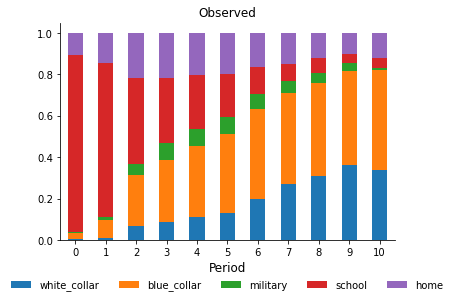

In [8]:
plot_choices(df_obs, "Observed")

### Estimation

Estimation of the model is rather time-consuming so we just take the estimated parameter values as given.

In [9]:
params = pd.read_pickle("material/params_revised.pkl")
params.head()

value  \
category          name                                
delta             delta                    0.785423   
wage_white_collar constant                 8.322815   
                  exp_school               0.098627   
                  exp_white_collar         0.121718   
                  exp_white_collar_square -0.141769   

                                                                                     comment  
category          name                                                                        
delta             delta                                                      discount factor  
wage_white_collar constant                 log of rental price if the base skill endowmen...  
                  exp_school               linear return to an additional year of schooli...  
                  exp_white_collar          return to experience, same sector, linear (wage)  
                  exp_white_collar_square  return to experience, same sector, quadratic (...

Now we can simulate a sample based on them and compare the fit between the observed and the simulated dataset. As the simulation is quite resource-intensive, we will again rely on a prepared dataset.

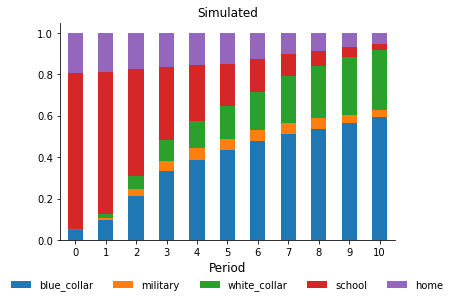

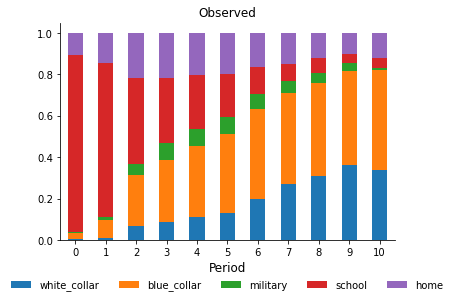

In [10]:
df_sim = pd.read_pickle("material/df_sim.pkl")

for label, df in [("Simulated", df_sim), ("Observed", df_obs)]:
    plot_choices(df, label)

### Causal variation

We can now evalaute the total causal effect of a $\$2,000$ tuition subsidy on average wages in the final period.

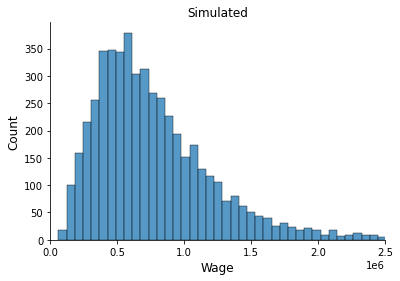

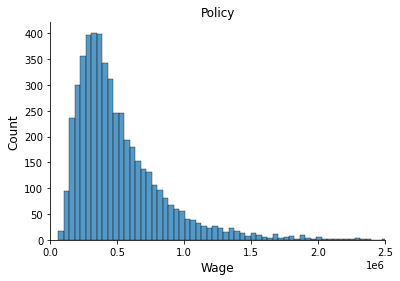

In [11]:
df_pol = pd.read_pickle("material/df_pol.pkl")
plot_wage_distribution(df_sim, df_pol)

### Mechanisms

How do individual decision change so that we observe the change in wages?

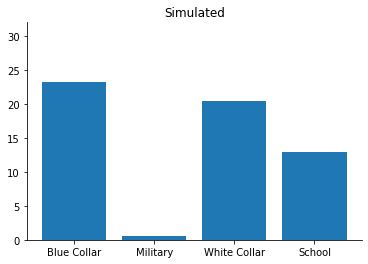

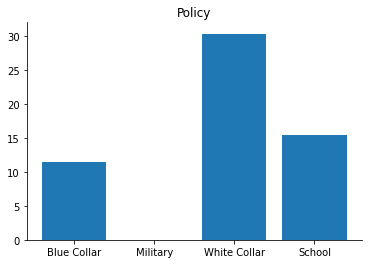

In [12]:
plot_final_human_capital(df_sim, df_pol)